### Importing libraries,packages and modules

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import RMSprop
from torch.optim import Adam
import shutil
import nibabel as nib
import skimage.transform as skTrans



###  Importing T1-MRI to T2-MRI translator a.k.a T1-T2 generator trained in task1.We incorrate T1-MRI to T2-MRI translator(generator) in dataloader to automatically load generated 3D Non-contrast T2 MRI image into 3D-resnets. Generator takes existing T1(contrast enhanced image) as input and translates it into T2(non contrast) image.

###  

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)


### Creating instance of generator class and loading the trained model

In [3]:
class Generator(nn.Module):
    def __init__(self, img_channels=1, num_features = 64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, kernel_size=3, stride=2, padding=1),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ]
        )

        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [4]:
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
genT2  = Generator(img_channels=1, num_residuals=9).to("cuda")
genT1  = Generator(img_channels=1, num_residuals=9).to("cuda")

In [6]:
opt_gen = torch.optim.Adam(
        list(genT2.parameters()) + list(genT1.parameters()),
        lr=3e-4,
        betas=(0.5, 0.999),
    )

In [7]:
load_checkpoint(
          "../input/updatedcheckpointssdp/genT2.pth (1).tar"  , genT2, opt_gen, 3e-4,
        )

=> Loading checkpoint


### Moving files to working directory

In [8]:
!cp -r "../input/t1images/exactT1/exactT1"  "/kaggle/working/"
!cp  "../input/t1images/test.csv" "/kaggle/working/"
!cp  "../input/t1images/train.csv" "/kaggle/working/"

In [9]:
!pip install git+https://github.com/facebookresearch/fvcore.git

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-25e9f4pn
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-25e9f4pn
  Resolved https://github.com/facebookresearch/fvcore.git to commit 652b17de55ed7ed43979d0d8175b2804621a3bed
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 499.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=65365 sha256=017d6c068a07d3f7ad980558ceeb2378663e1f926f6e89c6dba43ef899d1888c
  Stored in directory: /tmp/pip-ephem-wheel-cache-tq_u92rf/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=33dd80f7fb40fbf5234a807b5c81abd054ab3dafff471289d5a3c6776ddab7b2
  Stored in directory: /root/.cache/pip/wheels/aa/cc/ed/ca4e88beef656b01c84

###  Writing class for custom dataset and custom dataloader

In [10]:
class T1Dataset(Dataset):
    def __init__(self, csv_file, root_dir,transforms) :
        super().__init__()
        self.annotations = pd.read_csv(csv_file)
        self.root_dir    = root_dir
        self.transforms  = transforms
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
       
        img_path =  os.path.join(self.root_dir,self.annotations.iloc[index,0] + '_ceT1.nii')  
        
        img      =  nib.load(img_path).get_fdata()
       
        img = skTrans.resize(img, (200,200,15), order=1, preserve_range=True)
       
        
        img = torch.tensor(img).cuda().float() 
        img = img.view(1,200,200,15)
        T2_slices = []
        for i in range(15):
            ith_slice = img[0, :, :, i].view(1,200,200).cuda()
            T2_slices.append(genT2(ith_slice))
        t2_image = np.vstack([i.view(1,200,200).cpu().detach().numpy() for i in T2_slices])
        
        t2_image = torch.tensor(t2_image).view(1,15,200,200)
        label    = int(self.annotations.iloc[index,3]) - 1
        if self.transforms:
            t2_image = self.transforms(t2_image)
        return (t2_image,label)

In [11]:
train_set = T1Dataset('./train.csv',root_dir='./exactT1/',transforms=None)

###  Function to build a model and choose desired optimizer,loss function,learning rate and number of layers to freeze

In [12]:
def build_model(loss_function,optimizer,learning_rate,freeze_layers):
    model = torch.hub.load('facebookresearch/pytorchvideo', 'slow_r50', pretrained=True)
    model.blocks[0].conv = nn.Conv3d(1, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    model.blocks[-1].output_pool = nn.Sequential(nn.AdaptiveAvgPool3d(output_size=1),
                                             nn.Flatten(),
                                             nn.Linear(400,100),
                                             nn.LeakyReLU(0.1),
                                             nn.Linear(100,16),
                                             nn.LeakyReLU(0.1),
                                             nn.Linear(16,4),
                                             nn.LogSoftmax(dim=1))
    if optimizer == 'Adam':
        optim = torch.optim.Adam(model.parameters(),lr=learning_rate)
    else:
        optim = torch.optim.RMSprop(model.parameters(),lr=learning_rate)
    if(loss_function == 'cross_entropy'):
        criterion = nn.CrossEntropyLoss()
    else:
        pass
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device=device)
    layers = 0
    for param in model.parameters():
        layers += 1
        param.requires_grad = False
        if layers == freeze_layers:
            break
    return model,optim,criterion

In [13]:
model,optimizer,criterion = build_model('cross_entropy','Adam',3e-4,10)
print(model)

Downloading: "https://github.com/facebookresearch/pytorchvideo/archive/main.zip" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/pytorchvideo/model_zoo/kinetics/SLOW_8x8_R50.pyth" to /root/.cache/torch/hub/checkpoints/SLOW_8x8_R50.pyth


  0%|          | 0.00/248M [00:00<?, ?B/s]

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv3d(1, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
      (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (branch1_norm): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(64, 64, kernel_size=(1, 3, 3), stride=(1, 

### Visualizing 3D brain image(synthetic)

In [14]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
x = train_set[0][0]

fig,axs = plt.subplots(5,3,dpi=200,figsize=(50,50))
plot = 0
for i in range(5):
    for j in range(3):
        axs[i][j].imshow(x[0,plot,:,:],cmap='gray')
        axs[i][j].set_title('slice_' + str(plot+1))
        plot += 1
        plt.subplots_adjust()

### Function to train the model

In [15]:
from tqdm import tqdm
def train_model(model,optimizer,criterion,numepochs):
    epochs = numepochs
    train_losses = []
    train_loader = DataLoader(train_set,batch_size=5,shuffle=True)
    train_correct = []

    for i in tqdm(range(epochs)):
        trncorr = 0
        
    
   
        for batch_idx, (image, label) in enumerate(train_loader):
            image,label = image.cuda(),label.cuda()
            batch_idx +=1
        
        
            y_pred = model(image)  
            loss = criterion(y_pred, label)
 
        
            predicted = torch.max(y_pred.data, 1)[1]
            batchcorr = (predicted == label).sum()
            trncorr += batchcorr
        
       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'epoch: {i+1:2}  batch: {batch_idx:4} [{5*batch_idx:6}/{len(train_loader)*5}]  loss: {loss.item():10.8f}  \
Training accuracy: {trncorr.item()*100/(5*batch_idx):7.3f}%')
        train_correct.append(trncorr)
        train_losses.append(loss)
   
    return model,train_correct,train_losses

### Training!

In [16]:
model,train_correct,train_losses = train_model(model,optimizer,criterion,30)

  3%|▎         | 1/30 [02:18<1:07:06, 138.85s/it]

epoch:  1  batch:   16 [    80/80]  loss: 1.35948479  Training accuracy:  27.500%


  7%|▋         | 2/30 [04:24<1:01:13, 131.20s/it]

epoch:  2  batch:   16 [    80/80]  loss: 0.98747802  Training accuracy:  37.500%


 10%|█         | 3/30 [06:28<57:25, 127.61s/it]  

epoch:  3  batch:   16 [    80/80]  loss: 0.41560319  Training accuracy:  56.250%


 13%|█▎        | 4/30 [08:31<54:32, 125.87s/it]

epoch:  4  batch:   16 [    80/80]  loss: 0.35264152  Training accuracy:  53.750%


 17%|█▋        | 5/30 [10:35<52:07, 125.11s/it]

epoch:  5  batch:   16 [    80/80]  loss: 2.72419190  Training accuracy:  62.500%


 20%|██        | 6/30 [12:39<49:54, 124.75s/it]

epoch:  6  batch:   16 [    80/80]  loss: 0.55243433  Training accuracy:  60.000%


 23%|██▎       | 7/30 [14:42<47:40, 124.38s/it]

epoch:  7  batch:   16 [    80/80]  loss: 0.67581290  Training accuracy:  63.750%


 27%|██▋       | 8/30 [16:45<45:28, 124.01s/it]

epoch:  8  batch:   16 [    80/80]  loss: 1.03934598  Training accuracy:  71.250%


 30%|███       | 9/30 [18:49<43:22, 123.93s/it]

epoch:  9  batch:   16 [    80/80]  loss: 0.88628674  Training accuracy:  77.500%


 33%|███▎      | 10/30 [21:02<42:12, 126.62s/it]

epoch: 10  batch:   16 [    80/80]  loss: 0.82667869  Training accuracy:  68.750%


 37%|███▋      | 11/30 [23:14<40:37, 128.30s/it]

epoch: 11  batch:   16 [    80/80]  loss: 0.71061713  Training accuracy:  77.500%


 40%|████      | 12/30 [25:20<38:18, 127.70s/it]

epoch: 12  batch:   16 [    80/80]  loss: 0.74631751  Training accuracy:  86.250%


 43%|████▎     | 13/30 [27:25<35:55, 126.81s/it]

epoch: 13  batch:   16 [    80/80]  loss: 0.31733525  Training accuracy:  92.500%


 47%|████▋     | 14/30 [29:29<33:35, 125.97s/it]

epoch: 14  batch:   16 [    80/80]  loss: 0.03598958  Training accuracy:  92.500%


 50%|█████     | 15/30 [31:34<31:23, 125.55s/it]

epoch: 15  batch:   16 [    80/80]  loss: 0.14205855  Training accuracy:  80.000%


 53%|█████▎    | 16/30 [33:37<29:09, 124.97s/it]

epoch: 16  batch:   16 [    80/80]  loss: 0.33207861  Training accuracy:  67.500%


 57%|█████▋    | 17/30 [35:41<26:58, 124.52s/it]

epoch: 17  batch:   16 [    80/80]  loss: 0.35433751  Training accuracy:  76.250%


 60%|██████    | 18/30 [37:44<24:51, 124.28s/it]

epoch: 18  batch:   16 [    80/80]  loss: 0.11111586  Training accuracy:  90.000%


 63%|██████▎   | 19/30 [39:49<22:47, 124.31s/it]

epoch: 19  batch:   16 [    80/80]  loss: 0.60941362  Training accuracy:  90.000%


 67%|██████▋   | 20/30 [41:53<20:41, 124.15s/it]

epoch: 20  batch:   16 [    80/80]  loss: 0.08298697  Training accuracy:  95.000%


 70%|███████   | 21/30 [43:56<18:36, 124.03s/it]

epoch: 21  batch:   16 [    80/80]  loss: 0.00809472  Training accuracy:  96.250%


 73%|███████▎  | 22/30 [46:01<16:32, 124.09s/it]

epoch: 22  batch:   16 [    80/80]  loss: 0.07507435  Training accuracy:  92.500%


 77%|███████▋  | 23/30 [48:05<14:29, 124.21s/it]

epoch: 23  batch:   16 [    80/80]  loss: 0.61034381  Training accuracy:  91.250%


 80%|████████  | 24/30 [50:09<12:25, 124.19s/it]

epoch: 24  batch:   16 [    80/80]  loss: 0.02533969  Training accuracy:  88.750%


 83%|████████▎ | 25/30 [52:13<10:20, 124.12s/it]

epoch: 25  batch:   16 [    80/80]  loss: 0.31004915  Training accuracy:  92.500%


 87%|████████▋ | 26/30 [54:17<08:16, 124.16s/it]

epoch: 26  batch:   16 [    80/80]  loss: 0.12666878  Training accuracy:  93.750%


 90%|█████████ | 27/30 [56:21<06:12, 124.07s/it]

epoch: 27  batch:   16 [    80/80]  loss: 0.03905158  Training accuracy:  91.250%


 93%|█████████▎| 28/30 [58:25<04:08, 124.09s/it]

epoch: 28  batch:   16 [    80/80]  loss: 0.01453754  Training accuracy:  93.750%


 97%|█████████▋| 29/30 [1:00:28<02:03, 123.80s/it]

epoch: 29  batch:   16 [    80/80]  loss: 0.00729322  Training accuracy:  95.000%


100%|██████████| 30/30 [1:02:32<00:00, 125.09s/it]

epoch: 30  batch:   16 [    80/80]  loss: 0.00599040  Training accuracy:  92.500%


### Visualization of accuracy and loss

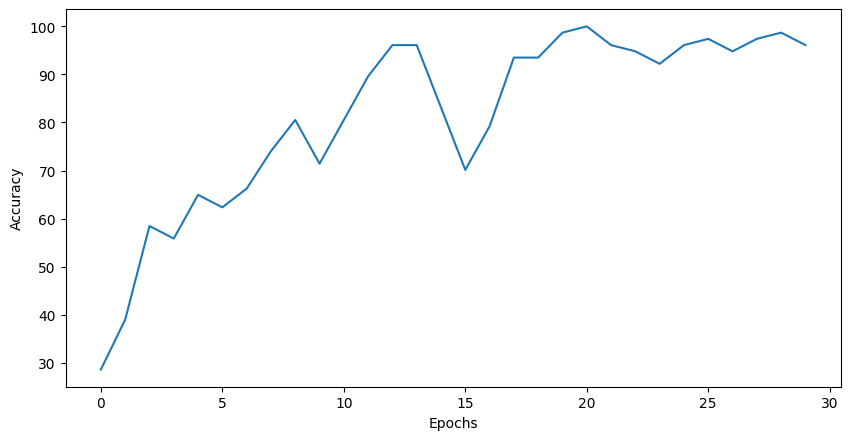

In [17]:
with torch.no_grad():
    matplotlib.rcParams.update({'font.size': 10})
    plt.figure(dpi=100,figsize=(10,5))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.plot([(t.cpu()/77)*100 for t in train_correct])
    plt.show()

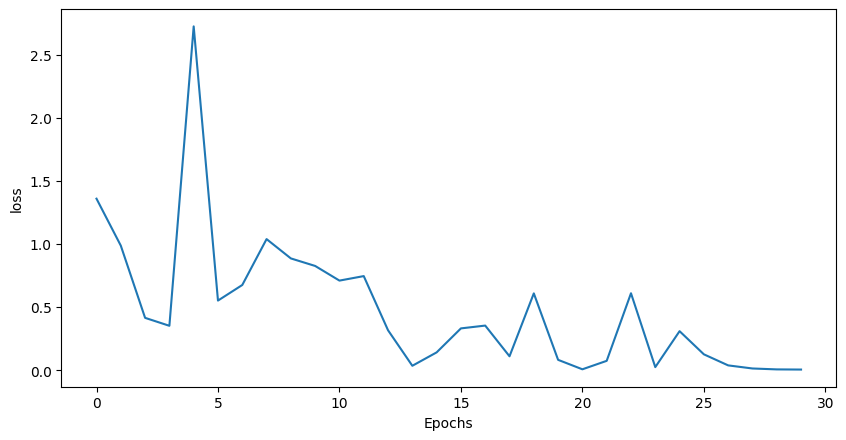

In [18]:
with torch.no_grad():
    matplotlib.rcParams.update({'font.size': 10})
    plt.figure(dpi=100,figsize=(10,5))
    plt.plot([t.cpu() for t in train_losses])
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.show()

In [19]:
torch.save(model.state_dict(),"T2Classification_Adam_CE")

## Validation task

In [20]:
test_set = T1Dataset('./test.csv',root_dir='./exactT1/',transforms=None)
test_loader = DataLoader(test_set,batch_size=1,shuffle=False)


In [1]:
model.load_state_dict(torch.load('./T2Classification_Adam_CE'))
model.eval()
with torch.no_grad():
    correct = 0
    preds =  []
    actual = []
    for img, label in test_loader:
        img,label = img.cuda(),label.cuda()
        y_val = model(img)
        predicted = torch.max(y_val,1)[1]
        
        correct += (predicted == label).sum()
        for i in label:
            actual.append(i.cpu().numpy())
        for i in predicted:
            preds.append(i.cpu().numpy())
print(f'Test accuracy: {correct.item()}/{len(test_loader)} = {correct.item()*100/(len(test_loader)):7.3f}%')

Test accuracy : 19/22 = 86.363%
